In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# characteristics:
# ---------------
# X: [165 x 1107]
# - wide matrix
# - all binary
# - some zero variance

# y:
# - regression problem
# - right skew distribution

# preprocessing:
# -------------
# - remove zero variance columns
# - use pca/pls for dimensionality reduction
# - log1p transform y

# resampling method:
# -----------------
# - repeated k-fold

# metrics:
# -------
# - r2 or rmse

# models:
# ------

In [65]:
y = pd.read_csv('data/permeability/permeability.csv', index_col=0)
X = pd.read_csv('data/permeability/fingerprints.csv', index_col=0)

In [66]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1098,X1099,X1100,X1101,X1102,X1103,X1104,X1105,X1106,X1107
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X['permeability'] = y['permeability'].values

In [68]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1099,X1100,X1101,X1102,X1103,X1104,X1105,X1106,X1107,permeability
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.520
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.120
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.405
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.730
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.680


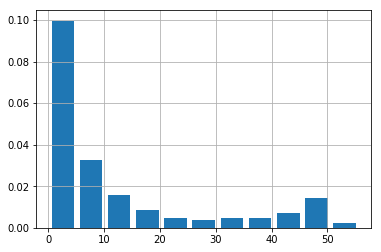

In [69]:
X['permeability'].hist(bins=11, rwidth=.8, density=True)

(array([0.15083942, 0.43575832, 0.40223845, 0.16759935, 0.26815897,
        0.26815897, 0.18435929, 0.21787916, 0.18435929, 0.11731955,
        0.36871858]),
 array([0.05826891, 0.41988164, 0.78149438, 1.14310711, 1.50471985,
        1.86633258, 2.22794531, 2.58955805, 2.95117078, 3.31278352,
        3.67439625, 4.03600899]),
 <a list of 11 Patch objects>)

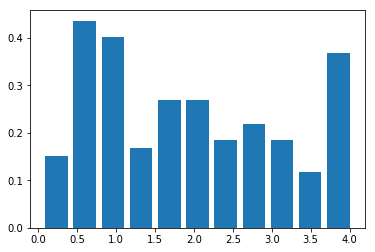

In [86]:
# y distribution after log1p transform
_ = plt.hist(np.log1p(y), bins=11, rwidth=.8, density=True)

In [70]:
kbins = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

permea_groups = kbins.fit_transform(X[['permeability']]).ravel()

In [71]:
pd.value_counts(permea_groups)

7.0    21
4.0    21
0.0    21
2.0    21
6.0    21
3.0    20
1.0    20
5.0    20
dtype: int64

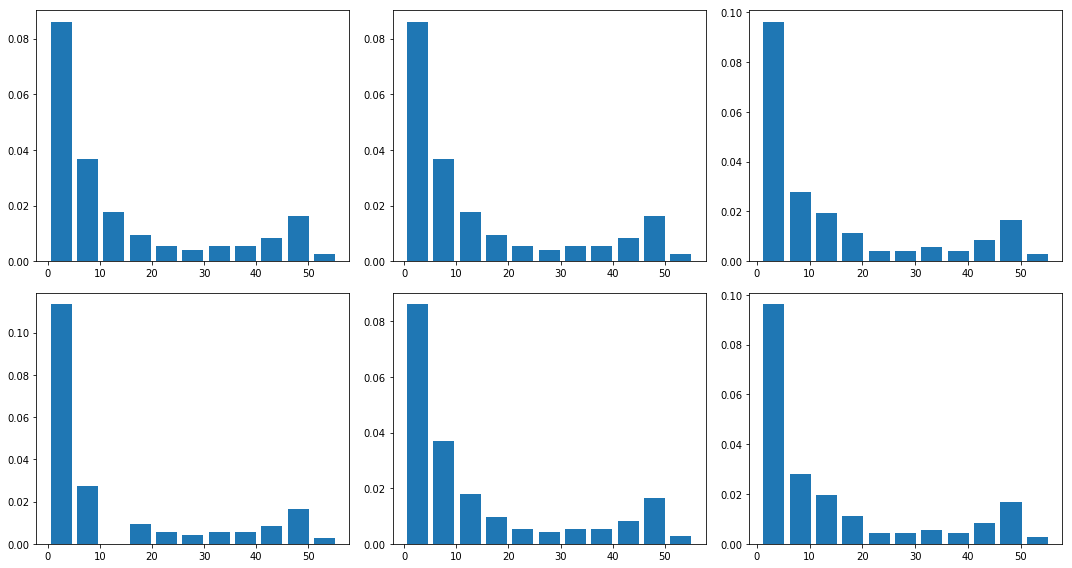

In [72]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

g_shuffle = GroupShuffleSplit(n_splits=6, test_size=.1, random_state=42)

for axi, (tr_idx, val_idx) in zip(ax.flat, 
                                  g_shuffle.split(X, y, groups=permea_groups)):
    y_tr = y.values[tr_idx]
    axi.hist(y_tr, bins=11, rwidth=.8, density=True)
    
fig.tight_layout()

In [73]:
kbins.bin_edges_

array([array([ 0.06  ,  0.7475,  1.55  ,  2.475 ,  4.91  ,  8.485 , 15.47  ,
       39.505 , 55.6   ])], dtype=object)

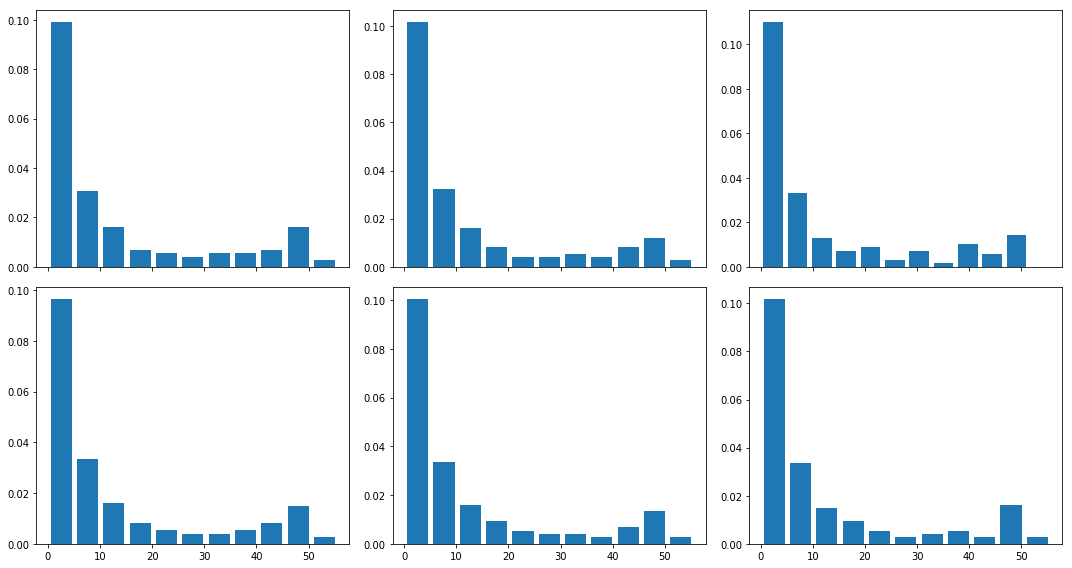

In [74]:
sf = ShuffleSplit(n_splits=6, test_size=.1, random_state=None)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True)

for axi, (tr_idx, val_idx) in zip(ax.flat, sf.split(X, y)):
    y_tr = y.values[tr_idx]
    axi.hist(y_tr, bins=11, rwidth=.8, density=True)
    
fig.tight_layout()

In [75]:
X = X.drop(columns='permeability')

In [77]:
y = y['permeability'].values

In [78]:
X.shape, y.shape

((165, 1107), (165,))

In [79]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1098,X1099,X1100,X1101,X1102,X1103,X1104,X1105,X1106,X1107
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X.dtypes.value_counts()

float64    1107
dtype: int64

In [81]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,165.0,0.230303,0.422308,0.0,0.0,0.0,0.0,1.0
X2,165.0,0.224242,0.418352,0.0,0.0,0.0,0.0,1.0
X3,165.0,0.212121,0.410055,0.0,0.0,0.0,0.0,1.0
X4,165.0,0.212121,0.410055,0.0,0.0,0.0,0.0,1.0
X5,165.0,0.212121,0.410055,0.0,0.0,0.0,0.0,1.0
X6,165.0,0.448485,0.498853,0.0,0.0,0.0,1.0,1.0
X7,165.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
X8,165.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
X9,165.0,0.018182,0.134015,0.0,0.0,0.0,0.0,1.0
X10,165.0,0.024242,0.154269,0.0,0.0,0.0,0.0,1.0


In [88]:
# preprocessing

y_log = np.log1p(y)

# zero-var

In [96]:
# remove near-zero variance
zerovar = VarianceThreshold(threshold=.05)
zerovar.fit(X)

VarianceThreshold(threshold=0.05)

In [97]:
(zerovar.variances_ >= 0.05).sum()

388

In [98]:
X_trans = zerovar.transform(X)
print("predictors shape after removing near-zero variance columns: {}".format(X_trans.shape))

predictors shape after removing near-zero variance columns: (165, 388)


In [99]:
# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((123, 1107), (42, 1107), (123,), (42,))

In [149]:
# resampling method
k10 = KFold(n_splits=10, random_state=42, shuffle=True)
s50 = ShuffleSplit(n_splits=50, test_size=.1, random_state=123)
scores = 'r2'

In [176]:
# pls model

pls_estimator = PLSRegression(scale=False)
pls_params = {'n_components': list(range(2, 20)), 
              #'scale':[True, False]
             }
pls_grid = GridSearchCV(pls_estimator, pls_params, scoring='r2', verbose=1,
                        n_jobs=4, cv=k10, return_train_score=True)

In [177]:
pls_grid.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.6s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=PLSRegression(copy=True, max_iter=500, n_components=2, scale=False, tol=1e-06),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [214]:
pls_grid.best_score_, pls_grid.best_params_

(0.5100705344579405, {'n_components': 9})

In [178]:
pls_cv_results = pd.DataFrame(pls_grid.cv_results_)

In [179]:
pls_cv_results.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,0.036759,0.003432,0.510071,0.906960,9,{'n_components': 9},1,0.617316,0.901287,0.422391,...,0.695119,0.906774,0.261388,0.914009,0.646573,0.898761,0.007952,0.006379,0.157356,0.005863
9,0.046087,0.002541,0.509174,0.930169,11,{'n_components': 11},2,0.634195,0.924255,0.531940,...,0.631022,0.927629,0.288690,0.936577,0.603350,0.924885,0.007124,0.005076,0.149507,0.006414
8,0.045350,0.002213,0.508316,0.917867,10,{'n_components': 10},3,0.623070,0.912579,0.482713,...,0.634818,0.919007,0.280488,0.924397,0.685732,0.910235,0.006501,0.004550,0.156198,0.006210
6,0.034997,0.005142,0.506738,0.893043,8,{'n_components': 8},4,0.629596,0.886957,0.405540,...,0.705123,0.891836,0.275007,0.903402,0.650886,0.881873,0.004180,0.007024,0.152922,0.007110
5,0.033375,0.003400,0.492632,0.868967,7,{'n_components': 7},5,0.662723,0.867418,0.400536,...,0.509085,0.868020,0.218701,0.876604,0.587173,0.856435,0.003758,0.006164,0.143950,0.006423
10,0.049756,0.004711,0.492534,0.936832,12,{'n_components': 12},6,0.702173,0.931354,0.503725,...,0.588627,0.935217,0.308374,0.940835,0.546662,0.931815,0.007061,0.006857,0.162054,0.005865
4,0.028632,0.002679,0.488738,0.835581,6,{'n_components': 6},7,0.688580,0.835518,0.204336,...,0.551356,0.834097,0.286829,0.845042,0.683139,0.825437,0.005597,0.005232,0.187083,0.007184
11,0.054545,0.002554,0.488621,0.943603,13,{'n_components': 13},8,0.764348,0.939122,0.506819,...,0.591854,0.939761,0.273305,0.949352,0.546285,0.940170,0.007359,0.004846,0.164942,0.005715
3,0.026040,0.003028,0.466447,0.780775,5,{'n_components': 5},9,0.546167,0.771588,0.183865,...,0.569374,0.785458,0.405816,0.782600,0.632934,0.768418,0.006902,0.004036,0.185194,0.007712
2,0.020201,0.003061,0.446119,0.733428,4,{'n_components': 4},10,0.580614,0.729087,-0.078401,...,0.630776,0.735586,0.522514,0.736131,0.621442,0.722846,0.006389,0.005808,0.249285,0.008919


In [180]:
n_comps = pls_cv_results['param_n_components'].values.astype(int)
tr_scores = pls_cv_results['mean_train_score'].values
val_scores = pls_cv_results['mean_test_score'].values

Text(0,0.5,'$r^2$')

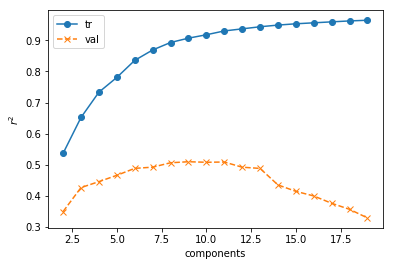

In [181]:
plt.plot(n_comps, tr_scores, 'o-', label='tr')
plt.plot(n_comps, val_scores, 'x--', label='val')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('$r^2$')

In [184]:
a = pd.DataFrame(pls_grid.best_estimator_.transform(X_train), 
                 columns=['PC{}'.format(i) for i in range(1,10)])
a['y_log'] = y_train

In [187]:
a.corr()['y_log']

PC1      0.557703
PC2      0.466440
PC3      0.336163
PC4      0.280403
PC5      0.212537
PC6      0.246672
PC7      0.183135
PC8     -0.153501
PC9      0.119402
y_log    1.000000
Name: y_log, dtype: float64

In [202]:
# pcr
pcr_estimator = make_pipeline(#StandardScaler(),
                              PCA(), 
                              LinearRegression())

pcr_params = {
    'pca__n_components': list(range(2, 30)),
}

pcr_grid = GridSearchCV(pcr_estimator, pcr_params, scoring='r2', 
                        cv=k10, verbose=1, return_train_score=True)

In [203]:
pcr_grid.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    7.4s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [204]:
pcr_grid.best_score_, pcr_grid.best_params_

(0.40642399300111487, {'pca__n_components': 24})

In [205]:
pcr_cv_results = pd.DataFrame(pcr_grid.cv_results_)

In [206]:
n_comps = pcr_cv_results['param_pca__n_components'].values.astype(int)
tr_scores = pcr_cv_results['mean_train_score'].values
val_scores = pcr_cv_results['mean_test_score'].values

Text(0,0.5,'$r^2$')

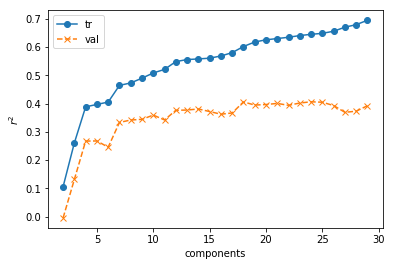

In [207]:
plt.plot(n_comps, tr_scores, 'o-', label='tr')
plt.plot(n_comps, val_scores, 'x--', label='val')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('$r^2$')

In [210]:
# ridge/lasso

elastic_estimator = ElasticNet(random_state=42)
elastic_params = {
   'alpha': np.logspace(np.log10(.01), np.log10(1.0), base=10, num=10), 
   'l1_ratio': np.linspace(0,1,11)
}

elastic_grid = GridSearchCV(elastic_estimator, elastic_params, scoring='r2', cv=k10, 
                            verbose=1, return_train_score=True, n_jobs=4)

In [211]:
elastic_grid.fit(X_train, y_train)

Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 315 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 1100 out of 1100 | elapsed:   25.4s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'alpha': array([0.01   , 0.01668, 0.02783, 0.04642, 0.07743, 0.12915, 0.21544,
       0.35938, 0.59948, 1.     ]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [212]:
elastic_grid.best_score_, elastic_grid.best_params_

(0.5938401228132402,
 {'alpha': 0.016681005372000592, 'l1_ratio': 0.7000000000000001})